# Experiment 9

This experiment will revist novelty scores and use them to determine the best model.

In [6]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [7]:
network_file_1 = "networks/Net3.inp"
network_file_2 = "networks/250701 K709vs2-Export.inp"
network_file_3 = "networks/Net6.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Net3: ", env1_start_pool)
print("Number of Start Nodes - Net3: ", len(env1_start_pool))
print("Number of Nodes - Net3: ", env1.graph_num_nodes)
print("Number of Links - Net3: ", env1.graph_num_links)

print("Start Pool - 250701 K709vs2-Export: ", env2_start_pool)
print("Number of Start Nodes - 250701 K709vs2-Export: ", len(env2_start_pool))
print("Number of Nodes - 250701 K709vs2-Export: ", env2.graph_num_nodes)
print("Number of Links - 250701 K709vs2-Export: ", env2.graph_num_links)

print("Start Pool - Net6: ", env3_start_pool)
print("Number of Start Nodes - Net6: ", len(env3_start_pool))
print("Number of Nodes - Net6: ", env3.graph_num_nodes)
print("Number of Links - Net6: ", env3.graph_num_links)

Start Pool - Net3:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Net3:  16
Number of Nodes - Net3:  97
Number of Links - Net3:  119
Start Pool - 250701 K709vs2-Export:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-0458', 'N-0459', 'N-0460',

In [8]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)
    
    # Run the simulations for no swarm control
    path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for node in start_nodes:
        print("Starting No Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=False, start_positions=[node], filepath=path)
        simulations_1.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_1
    
    # Run the simulations for naive swarm control
    path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for node in start_nodes:
        print("Starting Naive Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_2.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_2
    
    # Run the simulations for informed mean swarm control
    path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for node in start_nodes:
        print("Starting Informed Mean Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_3.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)    
    yield simulations_3
    
    # Run the simulations for informed median swarm control
    path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for node in start_nodes:
        print("Starting Informed Median Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_4.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_4

## Simulations

### Simulation 1 - Environment 1

In [9]:
start_nodes = env1_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-9/Env1"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']


In [10]:
simulations_9_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

no_swarm_env1 = next(simulations_9_1)
naive_swarm_env1 = next(simulations_9_1)
informed_mean_swarm_env1 = next(simulations_9_1)
informed_median_swarm_env1 = next(simulations_9_1)

Starting Simulation Batch -  notable-results/Experiment-9/Env1
Number of Agents:  10
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  15
Starting No Swarm Simulation from Start Node:  35
Starting No Swarm Simulation from Start Node:  131
Starting No Swarm Simulation from Start Node:  166
Starting No Swarm Simulation from Start Node:  167
Starting No Swarm Simulation from Start Node:  203
Starting No Swarm Simulation from Start Node:  219
Starting No Swarm Simulation from Start Node:  225
Starting No Swarm Simulation from Start Node:  231
Starting No Swarm Simulation from Start Node:  243
Starting No Swarm Simulation from Start Node:  253
Starting No Swarm Simulation from Start Node:  River
Starting No Swarm Simulation from Start Node:  Lake
Starting No Swarm Simulation from Start Node:  1
Starting No Swarm Simulation from Start Node:  2
Starting Naive Swarm

In [11]:
# Check the number of simulations is correct
assert len(no_swarm_env1) == len(start_nodes)
assert len(naive_swarm_env1) == len(start_nodes)
assert len(informed_mean_swarm_env1) == len(start_nodes)
assert len(informed_median_swarm_env1) == len(start_nodes)

### Simulation 2 - Environment 2

In [12]:
start_nodes = env2_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-9/Env2"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']


In [13]:
simulations_9_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)

no_swarm_env2 = next(simulations_9_2)
naive_swarm_env2 = next(simulations_9_2)
informed_mean_swarm_env2 = next(simulations_9_2)
informed_median_swarm_env2 = next(simulations_9_2)

Starting Simulation Batch -  notable-results/Experiment-9/Env2
Number of Agents:  10
Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  A2148
Starting No Swarm Simulation from Start Node:  A3007
Starting No Swarm Simulation from Start Node:  A3018
Starting No Swarm Simulation from Start Node:  A5065
Starting No Swarm Simulation from Start Node:  A5071
Starting No Swarm Simulation from Start Node:  A5078
Starting No Swarm Simulation from Start Node:  A5153
Starting No Swarm Simulation from Start Node:  A5169
Starting No Swarm Simulation from Start Node:  A5174
Starting No Swarm Simulation from Start Node:  A5175
Starting No Swarm Simulation from Start Node:  A5178
Starting No Swarm Simulation from Start Node:  A5183
Starting No Swarm Simulation from Start Node:  A5184
Starting No Swarm Simulation from Start Node:  A5185
Startin

In [14]:
# Check the number of simulations is correct
assert len(no_swarm_env2) == len(start_nodes)
assert len(naive_swarm_env2) == len(start_nodes)
assert len(informed_mean_swarm_env2) == len(start_nodes)
assert len(informed_median_swarm_env2) == len(start_nodes)

### Simulation 3 - Environment 3

In [15]:
start_nodes = env3_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-9/Env3"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['JUNCTION-12', 'JUNCTION-16', 'JUNCTION-20', 'JUNCTION-21', 'JUNCTION-38', 'JUNCTION-39', 'JUNCTION-40', 'JUNCTION-41', 'JUNCTION-45', 'JUNCTION-53', 'JUNCTION-74', 'JUNCTION-75', 'JUNCTION-81', 'JUNCTION-88', 'JUNCTION-96']


In [16]:
simulations_9_3 = run_simulation_batch(env3, num_agents, start_nodes, filepath, max_turns=max_turns)

no_swarm_env3 = next(simulations_9_3)
naive_swarm_env3 = next(simulations_9_3)
informed_mean_swarm_env3 = next(simulations_9_3)
informed_median_swarm_env3 = next(simulations_9_3)

Starting Simulation Batch -  notable-results/Experiment-9/Env3
Number of Agents:  10
Start Nodes:  ['JUNCTION-12', 'JUNCTION-16', 'JUNCTION-20', 'JUNCTION-21', 'JUNCTION-38', 'JUNCTION-39', 'JUNCTION-40', 'JUNCTION-41', 'JUNCTION-45', 'JUNCTION-53', 'JUNCTION-74', 'JUNCTION-75', 'JUNCTION-81', 'JUNCTION-88', 'JUNCTION-96']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  JUNCTION-12
Starting No Swarm Simulation from Start Node:  JUNCTION-16
Starting No Swarm Simulation from Start Node:  JUNCTION-20
Starting No Swarm Simulation from Start Node:  JUNCTION-21
Starting No Swarm Simulation from Start Node:  JUNCTION-38
Starting No Swarm Simulation from Start Node:  JUNCTION-39
Starting No Swarm Simulation from Start Node:  JUNCTION-40
Starting No Swarm Simulation from Start Node:  JUNCTION-41
Starting No Swarm Simulation from Start Node:  JUNCTION-45
Starting No Swarm Simulation from Start Node:  JUNCTION-53
Starting No Swarm Simulation from Start Node:  JUNCTION-74
Starting N

In [17]:
# Check the number of simulations is correct
assert len(no_swarm_env3) == len(start_nodes)
assert len(naive_swarm_env3) == len(start_nodes)
assert len(informed_mean_swarm_env3) == len(start_nodes)
assert len(informed_median_swarm_env3) == len(start_nodes)

## Analysis

In [106]:
from typing import List

# Read the results from the simulations
def read_results(simulations, swarm_type) -> List[pd.DataFrame]:
    results = []
    for sim in simulations:
        start_node, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        df['swarm_type'] = swarm_type
        df.swarm_type = swarm_type
        results.append(df)
    return results

def sim_results(batch_simulations, swarm_types):
    dres = pd.DataFrame()
    for simulation, swarm_type in zip(batch_simulations, swarm_types):
        dfoo = pd.DataFrame()
        foo = read_results(simulation, swarm_type)
        for bar in foo:
            bar = bar[['turn', 'start_node', 'swarm_type', 'link_novelty_score']]
            dfoo = pd.concat([dfoo, bar], axis=0, ignore_index=False)
        dres = pd.concat([dres, dfoo], axis=0, ignore_index=False)
    return dres 

#### Simulation 1 - Environment 1

A plot of the mean novelty score for each turn in the simulation.

Text(0, 0.5, 'Mean Novelty Score')

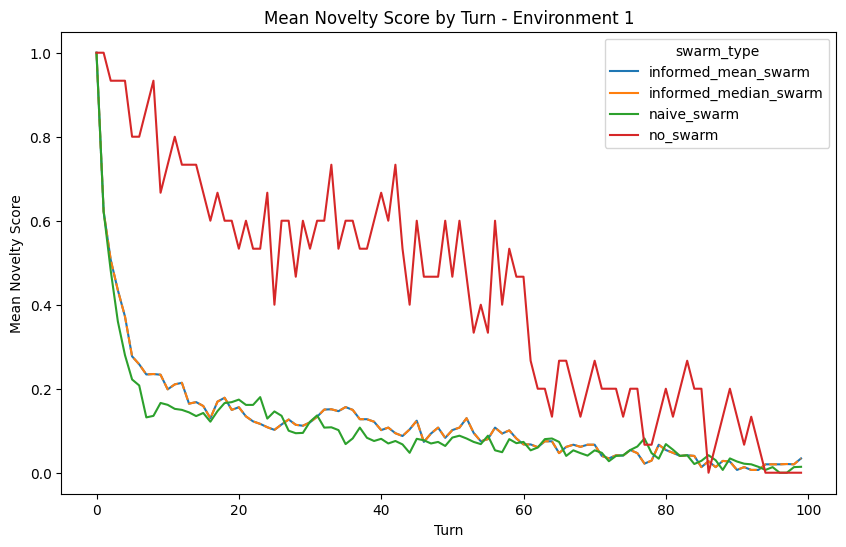

In [119]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
swarm_types = ['no_swarm', 'naive_swarm', 'informed_mean_swarm', 'informed_median_swarm']

df_env1 = sim_results(sims, swarm_types)
grouped = df_env1.groupby(['swarm_type', 'turn'])
mean_novelty = grouped['link_novelty_score'].mean()

unstacked = mean_novelty.unstack(level=0)

ax = unstacked.plot(kind='line', figsize=(10, 6), title='Mean Novelty Score by Turn - Environment 1')

# Make the informed swarm lines dashed
ax.lines[0].set_linestyle("-")
ax.lines[1].set_linestyle("--")

ax.set_xlabel('Turn')
ax.set_ylabel('Mean Novelty Score')


#### Simulation 2 - Environment 2

A plot of the mean novelty score for each turn in the simulation.

Text(0, 0.5, 'Mean Novelty Score')

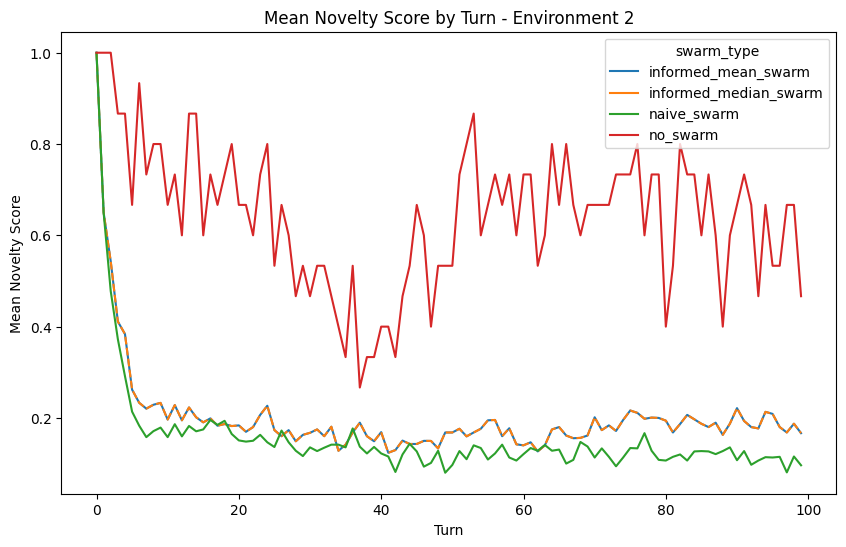

In [120]:
sims = [no_swarm_env2, naive_swarm_env2, informed_mean_swarm_env2, informed_median_swarm_env2]
swarm_types = ['no_swarm', 'naive_swarm', 'informed_mean_swarm', 'informed_median_swarm']

df_env2 = sim_results(sims, swarm_types)
grouped = df_env2.groupby(['swarm_type', 'turn'])
mean_novelty = grouped['link_novelty_score'].mean()

unstacked = mean_novelty.unstack(level=0)

ax = unstacked.plot(kind='line', figsize=(10, 6), title='Mean Novelty Score by Turn - Environment 2')

# Make the informed swarm lines dashed
ax.lines[0].set_linestyle("-")
ax.lines[1].set_linestyle("--")

ax.set_xlabel('Turn')
ax.set_ylabel('Mean Novelty Score')

#### Simulation 3 - Environment 3

A plot of the mean novelty score for each turn in the simulation.

Text(0, 0.5, 'Mean Novelty Score')

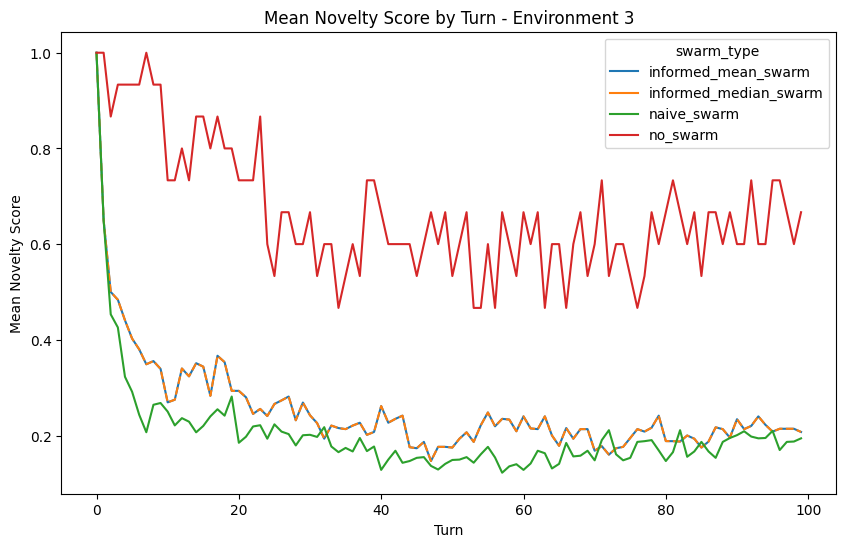

In [121]:
sims = [no_swarm_env3, naive_swarm_env3, informed_mean_swarm_env3, informed_median_swarm_env3]
swarm_types = ['no_swarm', 'naive_swarm', 'informed_mean_swarm', 'informed_median_swarm']

df_env3 = sim_results(sims, swarm_types)

grouped = df_env3.groupby(['swarm_type', 'turn'])
mean_novelty = grouped['link_novelty_score'].mean()

unstacked = mean_novelty.unstack(level=0)

ax = unstacked.plot(kind='line', figsize=(10, 6), title='Mean Novelty Score by Turn - Environment 3')

# Make the informed swarm lines dashed
ax.lines[0].set_linestyle("-")
ax.lines[1].set_linestyle("--")

ax.set_xlabel('Turn')
ax.set_ylabel('Mean Novelty Score')